In [2]:
import scipy
import os
import warnings
import numpy as np
from model import DGN
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torch.nn
import contextlib
import sys
import helper


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif', 'Arial', 'Liberation Serif']

ModuleNotFoundError: No module named 'model'

#### 1. inspect

#### 2. data preprocessing

In [ ]:
def normalize_matrix(connectivity_matrix):
    np.fill_diagonal(connectivity_matrix, 0)
    connectivity_matrix[np.logical_or(np.isinf(connectivity_matrix), np.isnan(connectivity_matrix))] = 0
    connectivity_matrix = connectivity_matrix.astype(float)
    
    return connectivity_matrix

In [3]:
import scipy.io
import numpy as np

connectivity_matrices_asd = []

for i in range(1, 155):
    mat = scipy.io.loadmat(f'data_nc_asd_L/data_nc_asd_L/ASD_LH/LHASDSub{i}.mat')
    connectivity_matrix = mat['views'][:, :, :]
    connectivity_matrix = [normalize_matrix(mat) for mat in connectivity_matrix]
    connectivity_matrices_asd.append(connectivity_matrix)

connectivity_matrices_asd = np.stack(connectivity_matrices_asd)

connectivity_matrices_control = []

for i in range(1, 186):
    mat = scipy.io.loadmat(f'data_nc_asd_L/data_nc_asd_L/NC_LH/LHNCSub{i}.mat')
    connectivity_matrix = mat['views'][:, :, :]
    connectivity_matrix = [normalize_matrix(mat) for mat in connectivity_matrix]
    connectivity_matrices_control.append(connectivity_matrix)

connectivity_matrices_control = np.stack(connectivity_matrices_control)


In [4]:
warnings.filterwarnings("ignore", category=UserWarning)

#### 3. train DGN for ASD

In [5]:
Dataset = "E" 
N_Subjects = 155
N_Nodes = 35
N_views = 6
N_max_epochs = 500
early_stop =  True
random_sample_size = 10
n_folds = 5
lr = 0.002
model_name = "asd_l_test"

#dimension of embeddings output by the first GDL layer (for each ROI)
CONV1 = CONV2 = CONV3 = 8

lambda_r = 200
lambda_b = 25
patience = 6
convergence_threshold = 0.01

#----------------------------------------------------------------------------#
#----------------------------------------------------------------------------#
#                 Below is not to be modified manually                       #
#----------------------------------------------------------------------------#
#----------------------------------------------------------------------------#

import helper

if Dataset.lower() not in ["e", "E", "s", "S"]:
    raise ValueError("Dataset options are E or S.")
    
if (Dataset.lower() == "e"):
    X = connectivity_matrices_asd
    N_Subjects = X.shape[0]
    N_Nodes = X.shape[1]
    N_views = X.shape[3]
else:
    X = helper.create_better_simulated(N_Subjects, N_Nodes) if N_views == 4 else helper.simulate_dataset(N_Subjects, N_Nodes, N_views)


CONFIG = {
        "X": X,
        "N_ROIs":  X.shape[1],
        "N_views":  X.shape[3],
        "N_max_epochs": N_max_epochs,
        "n_folds": n_folds,
        "random_sample_size": random_sample_size,
        "early_stop": early_stop,
        "model_name": model_name
    }

MODEL_PARAMS = {
        "N_ROIs": N_Nodes,
        "learning_rate" : lr,
        "n_attr": X.shape[3],
        "Linear1" : {"in": N_views, "out": CONV1},
        "conv1": {"in" : 1, "out": CONV1},
        
        "Linear2" : {"in": N_views, "out": CONV1*CONV2},
        "conv2": {"in" : CONV1, "out": CONV2},
        
        "Linear3" : {"in": N_views, "out": CONV2*CONV3},
        "conv3": {"in" : CONV2, "out": CONV3},
        "lambda_r" : lambda_r,
        "lambda_b" : lambda_b,
        "patience" : patience,
        "convergence_threshold" : convergence_threshold,
    }

lambda r 200.0 lambda b 25.0
********* FOLD 0 *********
Epoch: 0  |  cbt loss : 23.88 | reservoir loss : 0.0933 | bio loss : 0.62213 | total loss: 43.17 | median cbt mc 9.84 | Time Elapsed: 65.31 | 
Epoch: 10  |  cbt loss : 14.79 | reservoir loss : 0.0920 | bio loss : 0.58664 | total loss: 29.46 | median cbt mc 10.26 | Time Elapsed: 58.04 | 
Epoch: 20  |  cbt loss : 12.54 | reservoir loss : 0.0916 | bio loss : 0.59525 | total loss: 27.42 | median cbt mc 10.26 | Time Elapsed: 50.46 | 
Epoch: 30  |  cbt loss : 11.69 | reservoir loss : 0.0914 | bio loss : 0.59772 | total loss: 26.64 | median cbt mc 10.25 | Time Elapsed: 50.98 | 
Epoch: 40  |  cbt loss : 11.37 | reservoir loss : 0.0914 | bio loss : 0.59980 | total loss: 26.37 | median cbt mc 10.27 | Time Elapsed: 50.11 | 
Epoch: 50  |  cbt loss : 11.19 | reservoir loss : 0.0913 | bio loss : 0.59468 | total loss: 26.06 | median cbt mc 10.25 | Time Elapsed: 55.88 | 
Epoch: 60  |  cbt loss : 11.12 | reservoir loss : 0.0913 | bio loss : 0.5827

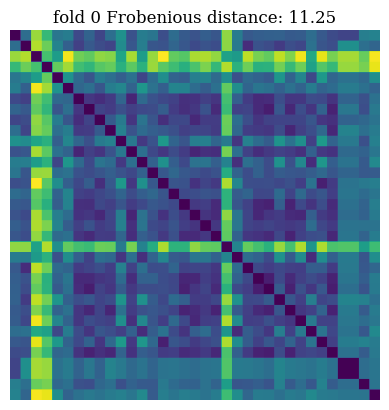

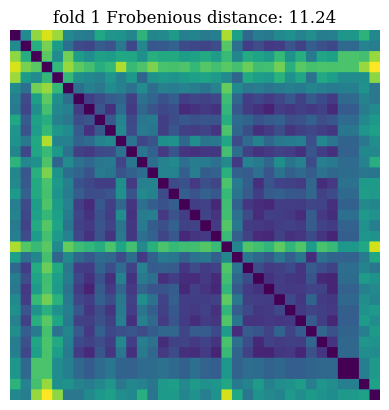

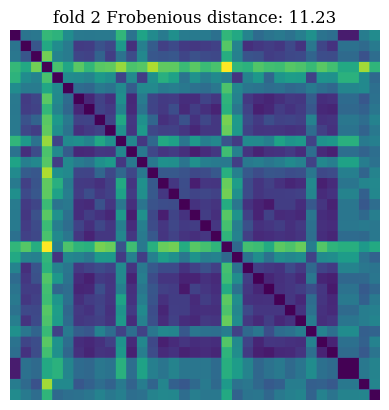

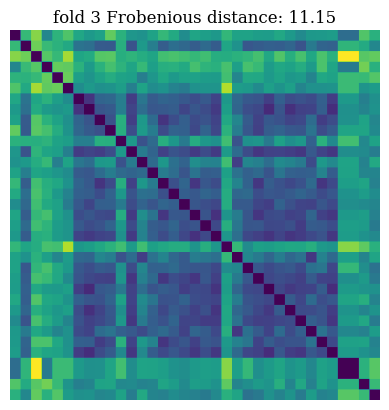

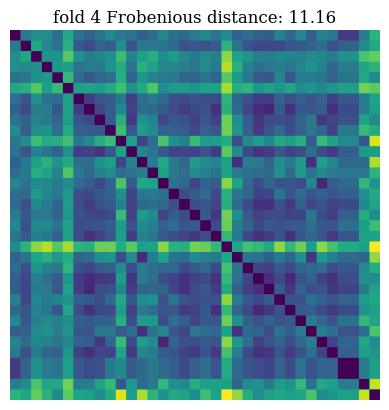

In [6]:
# lambda2 = 
np.random.seed(35813)
torch.manual_seed(35813)
models = DGN.train_model(
                CONFIG["X"],
                model_params=MODEL_PARAMS,
                
                
                n_max_epochs=CONFIG["N_max_epochs"],
                n_folds=CONFIG["n_folds"],
                random_sample_size=CONFIG["random_sample_size"],
                early_stop=CONFIG["early_stop"],
                model_name=CONFIG["model_name"])